In [1]:
import numpy as np
import os
import kagglehub
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn.functional as F

In [2]:
class DataSet(torch.utils.data.Dataset):
    def __init__(self, ds_file, labels, transform=None):
        self.transform = transform
        data_np = np.load(ds_file)
        labels_np = np.load(labels)
        self.data = torch.from_numpy(data_np)
        self.labels = torch.from_numpy(labels_np)
        self.length = data_np.shape[0]
    def __len__(self):
        return self.length
    def __getitem__(self, index):
        if self.transform:
            self.data = self.transform(self.data)

        return self.data[index], self.labels[index]

Using Colab cache for faster access to the 'crowd-counting' dataset.
Path to dataset files: /kaggle/input/crowd-counting
tensor([36], dtype=torch.uint8)


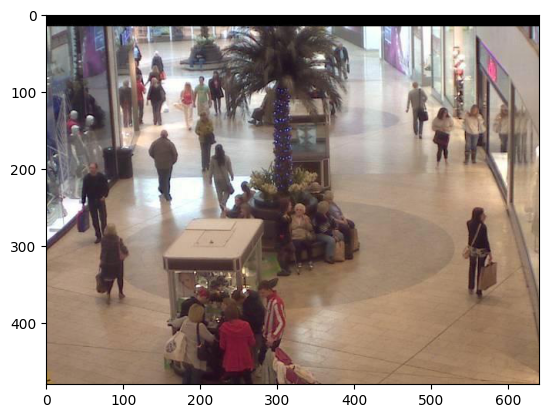

In [29]:
# Download latest version

path = kagglehub.dataset_download("fmena14/crowd-counting")

# train_data = np.load(os.path.join(path, "images.npy"))
all_data = DataSet(os.path.join(path, "images.npy"), os.path.join(path, "labels.npy"))
training_size = int(0.7 * len(all_data))
testing_size = (len(all_data)-training_size)

train_data, test_data = torch.utils.data.random_split(all_data, [training_size, testing_size])
# plt.imshow(train_data[0])
# train_data_tensor = torch.from_numpy(train_data).float()
# print(train_data_tensor.shape)
labels = np.load(os.path.join(path, "labels.npy"))


train_loader = torch.utils.data.DataLoader(train_data, batch_size=1, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=False, num_workers=2)

print("Path to dataset files:", path)

def imshow(img):
    # img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(npimg)



# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
# print(images)


# show images
imshow(images[0])
print(labels[0])

In [39]:
class ResNet50Transfer(nn.Module):
    def __init__(self, num_outputs, unlock_layers=0):
        super().__init__()
        self.resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Identity()
        self.fc1 = nn.Linear(in_features, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_outputs)
        for param in self.resnet.parameters():
            param.requires_grad = False
        if unlock_layers > 0:
            layers = list(self.resnet.parameters())
            unlock_layers = min(unlock_layers, len(layers))
            for param in layers[-unlock_layers:]:
                param.requires_grad = True

    def forward(self, x):
        x = self.resnet(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [33]:
def plot_accuracy_graphs(title, train_graph, test_graph, file_name):
  fig, axes = plt.subplots(1,2)
  axes[0].plot(train_graph)
  axes[0].set_title("Training Accuracy")
  axes[0].set_xlabel("Epoch")
  axes[0].set_ylabel("Error (average number of people missed)")
  axes[1].plot(test_graph)
  axes[1].set_title("Testing Accuracy")
  axes[1].set_xlabel("Epoch")
  axes[1].set_ylabel("Error (average number of people missed)")
  fig.suptitle(title)
  fig.tight_layout()
  fig.show()
  fig.savefig(file_name)

def plot_loss_graphs(title, train_graph, test_graph, file_name):
  fig, axes = plt.subplots(1,2)
  axes[0].plot(train_graph)
  axes[0].set_title("Training Loss")
  axes[0].set_xlabel("Epoch")
  axes[0].set_ylabel("Cross-Entropy Loss")
  axes[1].plot(test_graph)
  axes[1].set_title("Testing Loss")
  axes[1].set_xlabel("Epoch")
  axes[1].set_ylabel("Cross-Entropy Loss")
  fig.suptitle(title)
  fig.tight_layout()
  fig.show()
  fig.savefig(file_name)

In [27]:
def train(model, device, epochs):
    train_acc_history = np.zeros(epochs)
    test_acc_history = np.zeros(epochs)
    train_loss_history = np.zeros(epochs)
    test_loss_history = np.zeros(epochs)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters())

    for epoch in range(epochs):
        total = 0
        running_loss = 0.0
        running_acc = 0.0
        for _, data in enumerate(train_loader):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            labels_2d = torch.tensor(()).new_zeros((inputs.shape[0], 60))
            for j in range(inputs.shape[0]):
                labels_2d[j, labels[j].int()] = 1
            labels_2d = labels_2d.to(device)
            optimizer.zero_grad()
            outputs = model(inputs.permute(0, 3, 2, 1).float())
            loss = criterion(outputs.float(), labels_2d.float())
            loss.backward()
            optimizer.step()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            running_acc += torch.mean(torch.abs(predicted.float() - labels)).item() * labels.size(0)
            running_loss += loss.item()
        print(running_loss)
        train_acc_history[epoch] = running_acc / total
        train_loss_history[epoch] = running_loss / total
        total = 0
        running_loss = 0.0
        running_acc = 0.0

        with torch.no_grad():
            for _, data in enumerate(test_loader):
                inputs, labels = data
                inputs = inputs.to(device)
                labels = labels.to(device)
                labels_2d = torch.tensor(()).new_zeros((inputs.shape[0], 60))
                for j in range(inputs.shape[0]):
                    labels_2d[j, labels[j].int()] = 1
                labels_2d = labels_2d.to(device)
                outputs = model(inputs.permute(0, 3, 2, 1).float())
                loss = criterion(outputs.float(), labels_2d.float())
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                running_acc += torch.mean(torch.abs(predicted.float() - labels)).item() * labels.size(0)
                running_loss += loss.item()
        test_acc_history[epoch] = running_acc / total
        test_loss_history[epoch] = running_loss / total

    return train_acc_history, test_acc_history, train_loss_history, test_loss_history

cuda
4807.645097851753
4572.258242726326
4360.113912343979
3984.4374450445175
3324.3790385723114
2889.7824932932854
2638.040773332119
2365.9493837952614
2182.279584079981
1960.6241055354476
1796.9357964508235
1634.8853540206328
1537.346655447036
1442.5051129395142
1320.7089392039925
1279.090841144789
1135.9832429511007
1088.5285844145692
942.0179235050746
960.7046326544951
845.5972102108935
824.2245022396382
738.3275818447291
732.4090321352705
722.8481781657028
751.6087952335201
665.374985971117
578.5430162618923
538.6102530590867
586.4225240283577
552.2798708549492
530.7246848848204
515.5092465416478
510.68202483298296
468.6026235448645
536.0569487585268
411.09318387448707
351.674739118102
455.49020496097273
442.0799118887753
432.60484473674205
392.84046135529076
411.2219175817381
413.7933047152087
296.2952654562596
318.91236794684215
411.68735193700115
350.3630324809883
339.3590688525246
370.63493567850753


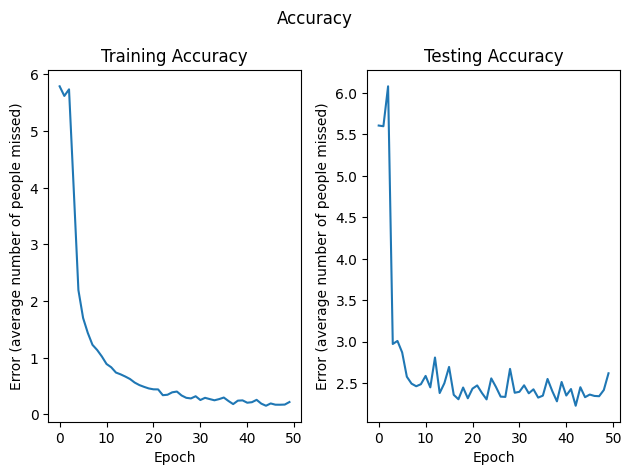

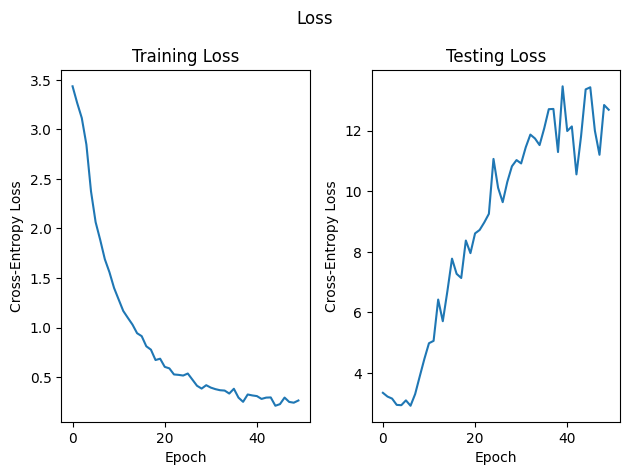

In [78]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = ResNet50Transfer(60, unlock_layers=9)
model = model.to(device)
train_acc_history, test_acc_history, train_loss_history, test_loss_history = train(model, device, 50)
torch.save(model.state_dict(), 'transfer_learning_model.pth')

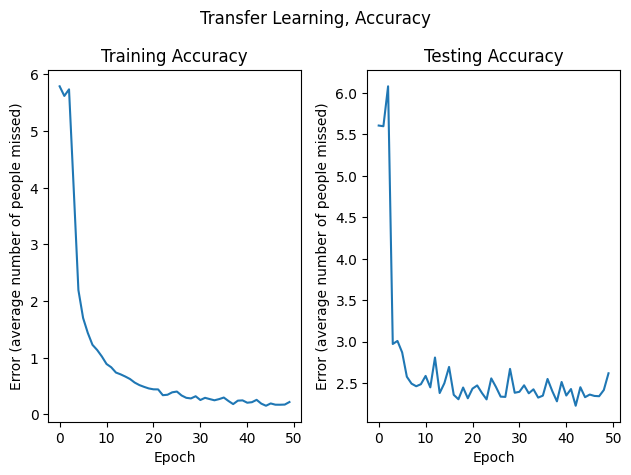

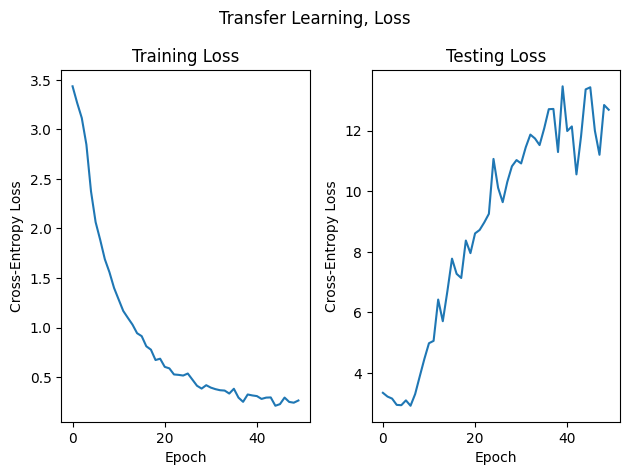

In [85]:
plot_accuracy_graphs("Transfer Learning, Accuracy", train_acc_history, test_acc_history, "transfer_learning_accuracy.png")
plot_loss_graphs("Transfer Learning, Loss", train_loss_history, test_loss_history, "transfer_learning_loss.png")

Predicted:  tensor([34], device='cuda:0')
Truth:  tensor([30], dtype=torch.uint8)
Average error on the test images (in number of people missed): 2.616667 


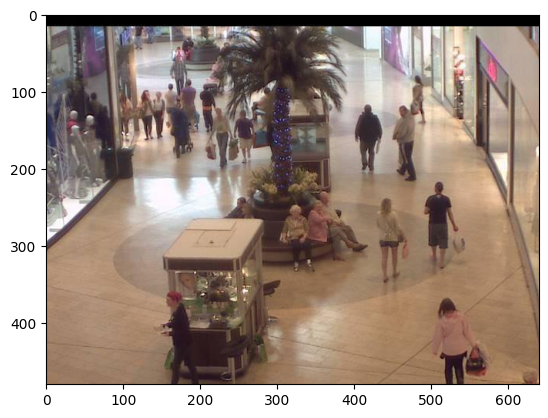

In [101]:
dataiter = iter(test_loader)
images, labels = next(dataiter)
outputs = model(images.to(device).permute(0, 3, 2, 1).float())

_, predicted = torch.max(outputs, 1)
imshow(images[0])
print('Predicted: ', predicted)
print('Truth: ', labels[0])

total = 0
total_error = 0.0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images.permute(0, 3, 2, 1).float())
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        total_error += torch.mean(torch.abs(predicted.float() - labels)).item() * labels.size(0)

print('Average error on the test images (in number of people missed): %f ' %(
    total_error / total))